<a href="https://colab.research.google.com/github/Mariana-MarquezA/Homelessness/blob/main/Homelessness_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The objective of this notebook is to make an exploratory analysis of the data provided by the HUD and prepare the data for further analysis. Preparing the data will include identification of missing values, subsection of data and quality control.

The 2020 [point-in-time count](https://www.kingcounty.gov/elected/executive/constantine/news/release/2020/July/01-homeless-count.aspx) of people experiencing homelessness for Seattle/King County was 11,751. This represents a 5% increase over the 2019 count and reflects similar trend across many counties in the western U.S.. A step towards addressing homelessness is improving our understanding of the relationship between local housing market factors and homelessness. 

The U.S. Department of Housing and Urban Development (HUD) produced a report in 2019 [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) that describes a model-based approach to understanding of the relationship between local housing market factors and homelessness. Our project is motivated by the goals of the HUD study:

"To continue progressing toward the goals of ending and preventing homelessness, we must further our knowledge of the basic community-level determinants of homelessness. The primary objectives of this study are to (1) identify market factors that have established effects on homelessness, (2) construct and evaluate empirical models of community-level homelessness.."

We will investigate whether there are alternative modeling approaches that outperform the models described in the HUD report.


## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
sns.set_theme(style='whitegrid')

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

import ipywidgets as widgets
from IPython.display import display


In [2]:
# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import RobustScaler

# Train-test splits and cross validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso

# Model metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import statsmodels.formula.api as smf
import statsmodels.api as sm

from google.colab import files

## The data

The [data](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/05b_analysis_file_update.csv) for this project are described in HUD's report [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) in the section titled DATA.

The data dictionary [HUD TO3 - 05b Analysis File - Data Dictionary.csv](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv) contains descriptions of all variables in the data set.




## Load the data

In [3]:
# Load the HUD report data
df = pd.read_csv('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/homelessness/05b_analysis_file_update.csv')

## Content exploration of the data set

The variable we are interested in predicting is 'pit_tot_hless_pit_hud' which is 'total homeless'. There seem to be useful variables such as 'median_income', 'number of evictions', 'urbanicity category', and other demographic variables.

Some variables are redundant or seem to be highly correlated. 

### Explore the data sources

We can use the dictionary to find the unique `Associated Domain` values. The dictionary of the data is quite useful because it classifies the variables for easier use. 

This section explores the sources of the data with the aid of the dictionary. It is important to make this exploration to determine the quality and the nature of the data available.

In [4]:
# Load the HUD report data dictionary
dictionary_df = pd.read_csv('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/homelessness/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv')

In [5]:
dictionary_df.head()

,Associated Domain,Variable,Variable Label,Derived,Source or Root Variable,Table Name(s)
0,Identifier,year,year,No,NaN,NaN
1,Identifier,cocnumber,continuum of care number,No,HUD,NaN
2,Outcome,pit_tot_shelt_pit_hud,total sheltered - HUD PIT,No,HUD PIT,NaN
3,Outcome,pit_tot_unshelt_pit_hud,total unsheltered - HUD PIT,No,HUD PIT,NaN
4,Outcome,pit_tot_hless_pit_hud,total homeless - HUD PIT,No,HUD PIT,NaN


The following are the unique classifications of 'Associated Domain':

In [6]:
dictionary_df['Associated Domain'].unique()

array(['Identifier', 'Outcome', 'Secondary Outcome', 'Subgroup',
       'Safety Net', 'Demographic', 'Housing', 'Economic', 'Local Policy',
       'Climate', 'Geography'], dtype=object)

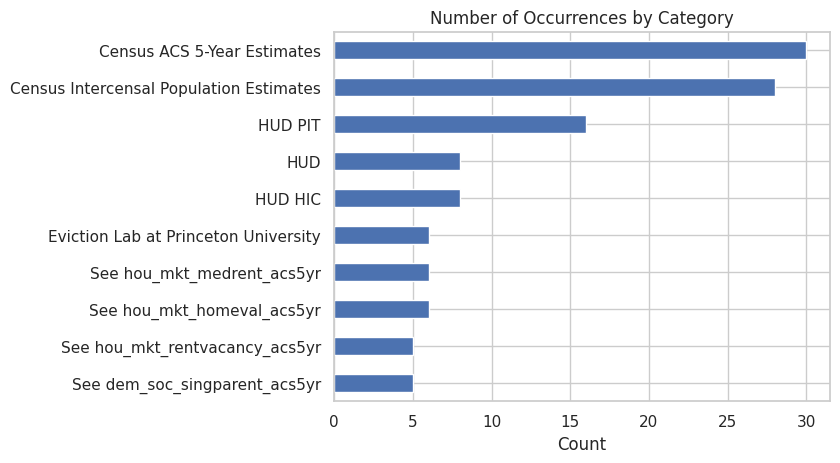

In [7]:
# Calculate counts of the different data sources
grouped_data = dictionary_df['Source or Root Variable'].value_counts()

# Horizontal bar graph 
df_first_10 = grouped_data.iloc[:10].plot(kind='barh')
plt.gca().invert_yaxis()

# Set the axis labels and plot title
plt.ylabel('')
plt.xlabel('Count')
plt.title('Number of Occurrences by Category')

# Display the plot
plt.show()


Most of our variables come from the Census and HUD. This is important to consider when choosing the variables for our model. For instance, the most common source are 5-year estimates. Estimates have shortcomings according to the way they are created; thus if we want to include variables from that category, it would be a good measure to investigate how reliable the estimate is.

## Select relevant subsets of the data

We will explore a subset of the full data set.

In [8]:
columns_to_keep = ["year", "cocnumber",
  
                  "pit_tot_hless_pit_hud", "pit_tot_shelt_pit_hud", "pit_tot_unshelt_pit_hud","dem_pop_pop_census",
  
                  "fhfa_hpi_2009", "ln_hou_mkt_medrent_xt", "hou_mkt_utility_xt", "hou_mkt_burden_own_acs5yr_2017", "hou_mkt_burden_sev_rent_acs_2017", 
                  
                  "hou_mkt_rentshare_acs5yr_2017", "hou_mkt_rentvacancy_xt", "hou_mkt_density_dummy", "hou_mkt_evict_count", "hou_mkt_ovrcrowd_acs5yr_2017", 
                   
                   "major_city", "suburban", "econ_labor_unemp_rate_BLS", "econ_labor_incineq_acs5yr_2017", "econ_labor_pov_pop_census_share",
           
                  "hou_pol_hudunit_psh_hud_share", "hou_pol_occhudunit_psh_hud", "hou_mkt_homeage1940_xt", "dem_soc_black_census",
                   
                   "dem_soc_hispanic_census", "dem_soc_asian_census", "dem_soc_pacific_census", "dem_pop_child_census", "dem_pop_senior_census", 
                   
                   "dem_pop_female_census", "dem_pop_mig_census", "d_dem_pop_mig_census_share", "dem_soc_singadult_xt", "dem_soc_singparent_xt", 
                   
                   "dem_soc_vet_xt", "dem_soc_ed_lessbach_xt", "dem_health_cost_dart", "dem_health_excesdrink_chr",
           
                  "env_wea_avgtemp_noaa", "env_wea_avgtemp_summer_noaa", "env_wea_precip_noaa", "env_wea_precip_annual_noaa", "census_region"]
    

In [9]:
df_new=df[columns_to_keep]

In [10]:
df_new.columns.nunique()

44

In [11]:
dictionary_small = dictionary_df[dictionary_df['Variable'].isin(columns_to_keep)]

We will explore the subset, the sources of its variables and the type of variables it includes:

How many variables of each Associated Domain are in the smaller data set?

In [12]:
# Create an array with the name of the variables in the dictionary
variable_values = dictionary_df['Variable'].unique()

# Identify the variables of the dictionary that are in the data set
filtered_variables = [var for var in variable_values if var in df_new.columns]

# Filter the rows in which 'Variable' matches with the filtered_variables
# Retrieve only the values of 'Associated Domain'
# Count the variables of each Associated Domain
domain_counts = dictionary_df[dictionary_df['Variable'].isin(filtered_variables)]['Associated Domain'].value_counts()

In [13]:
domain_counts

Demographic    16
Housing        10
Climate         4
Outcome         3
Economic        3
Safety Net      3
Identifier      2
Subgroup        2
Geography       1
Name: Associated Domain, dtype: int64

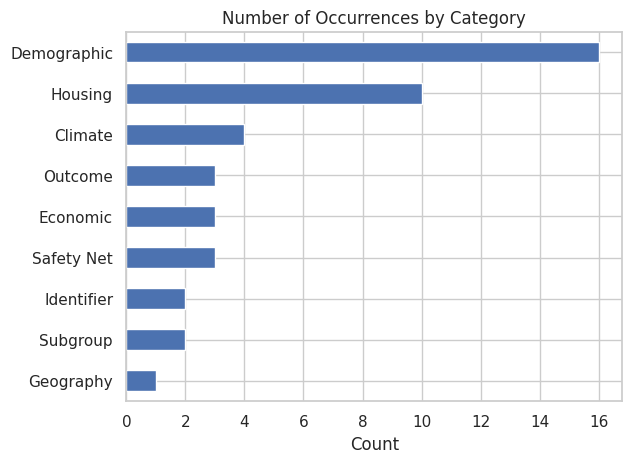

In [14]:
# Horizontal bar graph 
domain_counts.plot(kind='barh')
plt.gca().invert_yaxis()

# Set the axis labels and plot title
plt.ylabel('')
plt.xlabel('Count')
plt.title('Number of Occurrences by Category')

# Display the plot
plt.show()


What are the data sources in the smaller data set?

In [15]:
# Filter the rows in which 'Variable' matches with the filtered_variables
# Retrieve only the values of 'Source or Root Variable'
# Count the variables of each Source or Root Variable
source_counts = dictionary_df[dictionary_df['Variable'].isin(filtered_variables)]['Source or Root Variable'].value_counts()

# Create dataframe
df_source_counts = pd.DataFrame({'Source or Root Variable': source_counts.index, 'Count': source_counts.values})

In [16]:
display(df_source_counts.head(10))

,Source or Root Variable,Count
0,Census Intercensal Population Estimates,8
1,NOAA nClimDiv\nNOAA Climate at a Glance System,4
2,HUD,3
3,HUD PIT,3
4,See hou_mkt_burden_sev_rent_acs5yr,1
5,Census ACS 5-Year Estimates,1
6,See dem_pop_mig_census_share,1
7,See hou_mkt_medrent_acs5yr,1
8,See dem_soc_vet_acs5yr,1
9,See dem_soc_singparent_acs5yr,1


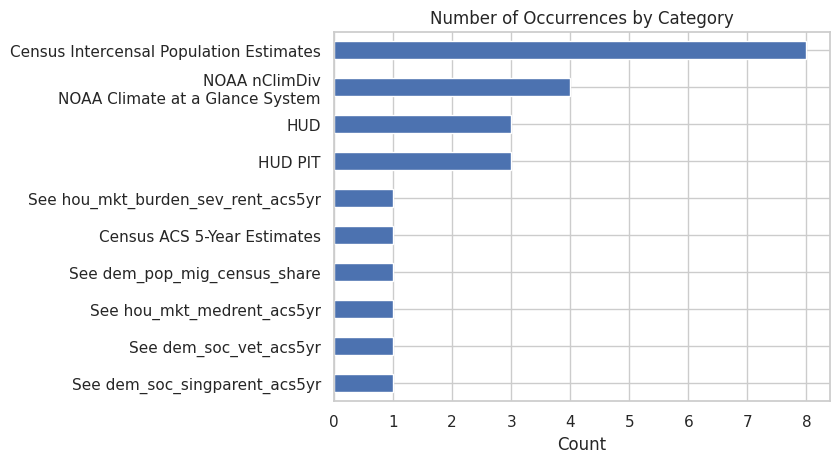

In [17]:
# Horizontal bar graph 
source_counts.iloc[:10].plot(kind='barh')
plt.gca().invert_yaxis()

# Set the axis labels and plot title
plt.ylabel('')
plt.xlabel('Count')
plt.title('Number of Occurrences by Category')

# Display the plot
plt.show()


# Rename columns

In [18]:
df = df_new.rename(columns = {"cocnumber":"coc_number",
  
                          "pit_tot_hless_pit_hud":"total_homeless", 
                          "pit_tot_shelt_pit_hud":"total_sheltered", 
                          "pit_tot_unshelt_pit_hud":"total_unsheltered",
                          "dem_pop_pop_census":"total_population",
  
                          "fhfa_hpi_2009":"house_price_index_2009", 
                          "ln_hou_mkt_medrent_xt":"log_median_rent", 
                          "hou_mkt_utility_xt":"utility_costs", 
                          "hou_mkt_burden_own_acs5yr_2017":"percentage_owners_cost_burden_2016", 
                          "hou_mkt_burden_sev_rent_acs_2017":"percentage_renters_severe_cost_burden_2016", 
                          "hou_mkt_rentshare_acs5yr_2017":"share_renters_2016", 
                          "hou_mkt_rentvacancy_xt":"rental_vacancy_rate", 
                          "hou_mkt_density_dummy":"high_housing_density", 
                          "hou_mkt_evict_count":"number_eviction", 
                          "hou_mkt_ovrcrowd_acs5yr_2017":"share_overcrowded_units_2016", 
                          "major_city":"city_or_urban", 
           
                          "econ_labor_unemp_rate_BLS":"rate_unemployment", 
                          "econ_labor_incineq_acs5yr_2017":"gini_coefficient_2016", 
                          "econ_labor_pov_pop_census_share":"poverty_rate",
           
                          "hou_pol_hudunit_psh_hud_share":"share_HUD_units", 
                          "hou_pol_occhudunit_psh_hud":"HUD_unit_occupancy_rate", 
                          "hou_mkt_homeage1940_xt":"share_built_before_1940",
           
                          "dem_soc_black_census":"total_black", 
                          "dem_soc_hispanic_census":"total_latino_hispanic", 
                          "dem_soc_asian_census":"total_asian", 
                          "dem_soc_pacific_census":"total_pacific_islander", 
                          "dem_pop_child_census":"total_population_0_19", 
                          "dem_pop_senior_census":"total_population_65_plus", 
                          "dem_pop_female_census":"total_female_population", 
                          "dem_pop_mig_census":"net_migration", 
                          "d_dem_pop_mig_census_share":"migration_4_year_change", 
                          "dem_soc_singadult_xt":"proportion_one_person_households", 
                          "dem_soc_singparent_xt":"share_under_18_with_single_parent", 
                          "dem_soc_vet_xt":"share_veteran_status", 
                          "dem_soc_ed_lessbach_xt":"share_no_bachelors", 
                          "dem_health_cost_dart":"medicare_reimbursements_per_enrollee", 
                          "dem_health_excesdrink_chr":"percentage_excessive_drinking",
           
                          "env_wea_avgtemp_noaa":"average_Jan_temperature", 
                          "env_wea_avgtemp_summer_noaa":"average_summer_temperature", 
                          "env_wea_precip_noaa":"total_Jan_precipitation", 
                          "env_wea_precip_annual_noaa":"total_annual_precipitation"})

# Are the data suitable for answering the question?

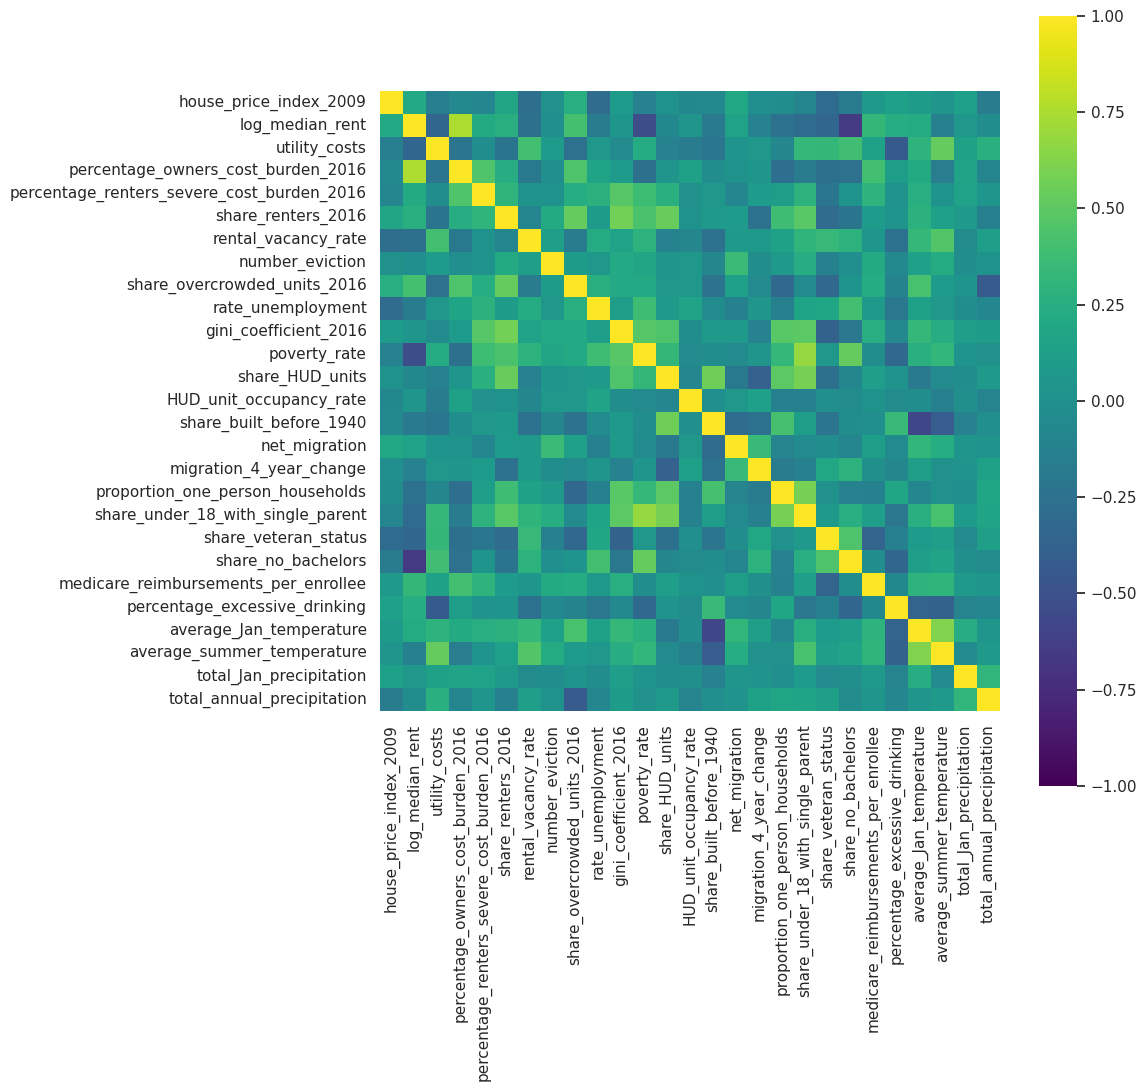

In [19]:
# List of variables to exclude from the matrix: Dummy, categorical, and total variables
variables_exclude = ['coc_number', 'total_population', 'total_homeless','total_sheltered', 'total_unsheltered', 
                   'total_black', 'total_latino_hispanic', 'total_asian', 'total_pacific_islander', 
                   'total_population_0_19', 'total_population_65_plus', 'total_female_population', 
                   'year', 'rate_unsheltered', 'rate_sheltered','census_region','census_region_1',
                   'census_region_2', 'census_region_3', 'census_region_4', 'city_or_urban', 'high_housing_density', 'suburban']

# Filter variables
numerical_columns = [col for col in df.columns if col not in variables_exclude]

# Calculate the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, cmap='viridis')
plt.show()


# Quality Control

We check for out-of-range values or values that do not match what we want to analyze

In [20]:
df.agg((min,max)).T

,min,max
year,2010,2017
coc_number,AK-500,WY-500
total_homeless,7.0,76501.0
total_sheltered,3.0,72565.0
total_unsheltered,0.0,42828.0
total_population,29344,11058958
house_price_index_2009,-26.497087,63.864007
log_median_rent,1.239243,2.874838
utility_costs,5.6,22.6
percentage_owners_cost_burden_2016,8.072322,22.955448


By looking at the table above, we can see that the range of each variable seems to be appropiate.

# Identify and deal with missing values

The first step for identifying missing values is to use `info` and compare the number of entries with the count of non-null values.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 44 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        3008 non-null   int64  
 1   coc_number                                  3008 non-null   object 
 2   total_homeless                              2994 non-null   float64
 3   total_sheltered                             2994 non-null   float64
 4   total_unsheltered                           2994 non-null   float64
 5   total_population                            3008 non-null   int64  
 6   house_price_index_2009                      3008 non-null   float64
 7   log_median_rent                             1504 non-null   float64
 8   utility_costs                               1504 non-null   float64
 9   percentage_owners_cost_burden_2016          3008 non-null   float64
 10  percentage_r

<Axes: >

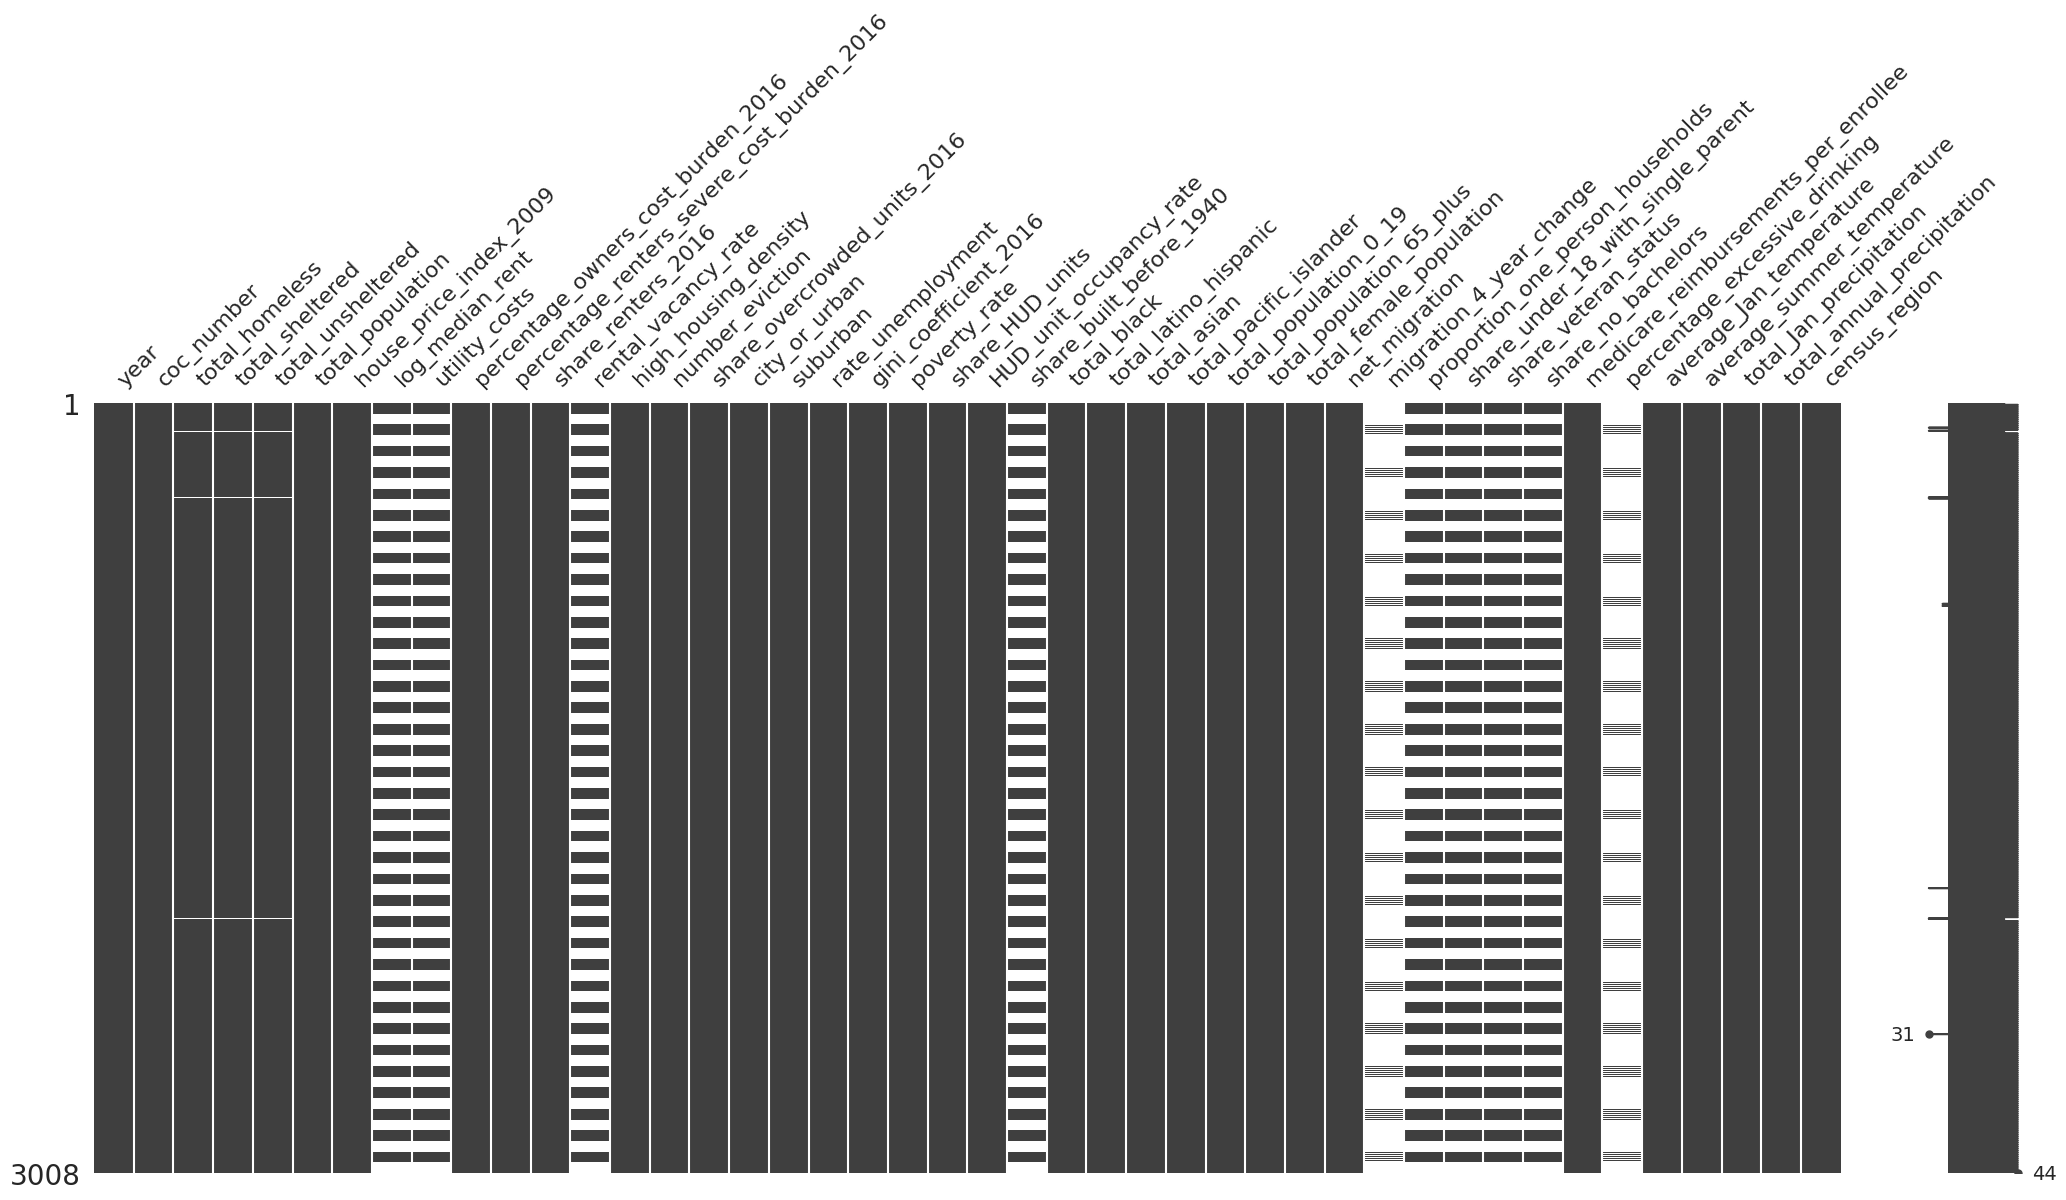

In [22]:
msno.matrix(df)

We can have a better view of the missing values with a matrix. It is noticeable that the matrix above shows some variables with missing values in constant intervals. Depending on how the data set is ordered, it can mean that the variables are missing values in certain periods or groups.

We need to manage the missing values. First, we get rid of the rows in which "total_homeless" is missing. Since "total_homeless" is our target variable we want to include only the rows in which its value is known. For our model to remain unbiased, we need to avoid imputation in the target variable.

In [23]:
df = df.loc[df['total_homeless'].notna()]

We create a function to count the missing values per year and have a better idea of where are the missing values in the data set.

In [24]:
def count_missing_values(df):
    variables = df.columns
    years = df['year'].unique()

    missing_values = []

    for variable in variables:
        n_missing_by_year = []
        for year in years:
            n_missing = df[df['year'] == year][variable].isnull().sum()
            n_missing_by_year.append(n_missing)
        missing_values.append(n_missing_by_year)

    result = pd.DataFrame(missing_values, columns=years, index=variables)
    return result



In [25]:
count_missing_values(df)

,2010,2011,2012,2013,2014,2015,2016,2017
year,0,0,0,0,0,0,0,0
coc_number,0,0,0,0,0,0,0,0
total_homeless,0,0,0,0,0,0,0,0
total_sheltered,0,0,0,0,0,0,0,0
total_unsheltered,0,0,0,0,0,0,0,0
total_population,0,0,0,0,0,0,0,0
house_price_index_2009,0,0,0,0,0,0,0,0
log_median_rent,373,0,375,0,373,0,374,0
utility_costs,373,0,375,0,373,0,374,0
percentage_owners_cost_burden_2016,0,0,0,0,0,0,0,0


The table above shows that some variables are only available every other year. This is expected as many sources from our data set do not publish or collect data uniformly. Since 2017 is the only year in which there are no missing values, we will select the data from 2017 to construct our model.

In [26]:
df=df[df['year'] == 2017]

# Create relevant derived variables as new columns

Create new variables `rate_homeless`, `rate_sheltered`, and `rate_unsheltered` in the data frame `df_2017` that are the counts per 10,000 people in the population. We need to do this in order to have comparable predictors. Additionally, some optimization algorithms presupose the variables are on the same scale.

In [27]:
df.loc[:, 'rate_homeless'] = df['total_homeless'] / (df['total_population'] / 10_000)
df.loc[:, 'rate_sheltered'] = df['total_sheltered'] / (df['total_population'] / 10_000)
df.loc[:, 'rate_unsheltered'] = df['total_unsheltered'] / (df['total_population'] / 10_000)

<ipython-input-27-659a6eb75e09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'rate_homeless'] = df['total_homeless'] / (df['total_population'] / 10_000)
<ipython-input-27-659a6eb75e09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'rate_sheltered'] = df['total_sheltered'] / (df['total_population'] / 10_000)
<ipython-input-27-659a6eb75e09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

We should note that the demographic variables (race, gender, age) are given as total counts. We will also convert these totals to percentages.

In [28]:
df.loc[:, 'percent_black'] = df['total_black'] / df['total_population']
df.loc[:, 'percent_latino_hispanic'] = df['total_latino_hispanic'] / df['total_population']
df.loc[:, 'percent_asian'] = df['total_asian'] / df['total_population']
df.loc[:, 'percent_pacific_islander'] = df['total_pacific_islander'] / df['total_population']
df.loc[:, 'percent_population_0_19'] = df['total_population_0_19'] / df['total_population']
df.loc[:, 'percent_population_65_plus'] = df['total_population_65_plus'] / df['total_population']
df.loc[:, 'percent_female_population'] = df['total_female_population'] / df['total_population']

<ipython-input-28-6c3844d27760>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'percent_black'] = df['total_black'] / df['total_population']
<ipython-input-28-6c3844d27760>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'percent_latino_hispanic'] = df['total_latino_hispanic'] / df['total_population']
<ipython-input-28-6c3844d27760>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [29]:
variable_remove = ['total_sheltered', 'total_unsheltered', 'total_black', 
                   'total_latino_hispanic', 'total_asian', 'total_pacific_islander', 
                   'total_population_0_19', 'total_population_65_plus', 'total_female_population', 
                   'year', 'rate_unsheltered', 'rate_sheltered']

In [30]:
df = df.drop(columns = variable_remove)

We want to use 'census_region' as a dummy variable. But it is coded as an int. We will use `get_dummies` to create the variables we need. We will not remove the census_region variable because it may be useful later on.

In [31]:
df['census_region'].info()

<class 'pandas.core.series.Series'>
Int64Index: 374 entries, 7 to 3007
Series name: census_region
Non-Null Count  Dtype
--------------  -----
374 non-null    int64
dtypes: int64(1)
memory usage: 5.8 KB


In [32]:
df['census_region'].unique()

array([4, 3, 1, 2])

In [33]:
# Create dummies for census_region
dummies = pd.get_dummies(df['census_region'], prefix='census_region')

# Concatenate the dummies with the original DataFrame
df = pd.concat([df, dummies], axis=1)

# Export the clean .csv file

In [35]:
df.to_csv('homelessness_clean.csv', encoding = 'utf-8-sig') 
files.download('homelessness_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>